In [ ]:
# mount google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# draw ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_roc_curve(test_y, probs):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(test_y))]
    # calculate scores
    ns_auc = roc_auc_score(test_y, ns_probs)
    auc = roc_auc_score(test_y, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
    fpr, tpr, _ = roc_curve(test_y, probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, linestyle='--', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.legend()
    # show the plot
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/application_train_cleaned_use_new.csv", index_col=False).iloc[:,1:]
df_y = df.TARGET
df_x = df.drop(columns='TARGET')

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=2020, shuffle = True)

#remove col whose missing value is greater than 1000
X_train = X_train.loc[:,col_selected]
X_test = X_test.loc[:,col_selected]
print("Train: " , X_train.shape)
print("Test: " , X_test.shape)

Train:  (44394, 118)
Test:  (21867, 118)


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
X_train_categorical = X_train.loc[:, X_train.dtypes == np.object]
X_train_continuous = X_train.loc[:, X_train.dtypes != np.object]
X_test_categorical = X_test.loc[:, X_test.dtypes == np.object]
X_test_continuous = X_test.loc[:, X_test.dtypes != np.object]

enc = OrdinalEncoder()
enc.fit(X_train_categorical)
X_train_categorical_enc = enc.transform(X_train_categorical)
X_test_categorical_enc = enc.transform(X_test_categorical)

X_train_enc = pd.concat([pd.DataFrame(X_train_categorical_enc, columns = X_train_categorical.columns, index = X_train_categorical.index), X_train_continuous], axis=1) 
X_test_enc = pd.concat([pd.DataFrame(X_test_categorical_enc, columns = X_test_categorical.columns, index = X_test_categorical.index), X_test_continuous], axis=1)

Optimal number of features : 101


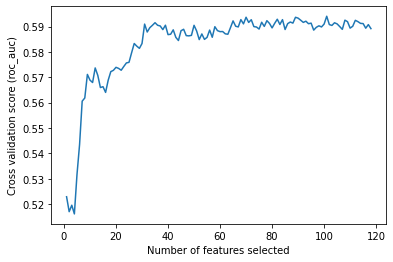

In [ ]:
# from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# sk = SelectKBest(mutual_info_classif, k=15)
# sk.fit(X_train_enc, y_train)
# col_selected = X_train_enc.columns[sk.get_support(indices=True)]
# print(col_selected)

rfecv = RFECV(DecisionTreeClassifier(), step = 1, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv.fit(X_train_enc, y_train)
col_selected = X_train_enc.columns[rfecv.get_support(indices=True)]

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc_auc)")
plt.plot(range(1,len(rfecv.grid_scores_) + 1),
         rfecv.grid_scores_)
plt.show()

In [ ]:
trainlen = X_train_enc.shape[0]
dataset = pd.concat([X_train.loc[:,col_selected], X_test.loc[:,col_selected]], axis = 0)
dataset_dummies = pd.get_dummies(dataset)
X_train_dummies = dataset_dummies.iloc[:trainlen, :]
X_test_dummies = dataset_dummies.iloc[trainlen:, :]
print("Train: " , X_train_dummies.shape)
print("Test: " , X_test_dummies.shape)

Train:  (44394, 196)
Test:  (21867, 196)


In [ ]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks, NeighbourhoodCleaningRule
print("Train: " , X_train_dummies.shape)
print("positive: " , np.sum(y_train == 1))
print("negative " , np.sum(y_train == 0))
cf = (X_train_dummies.dtypes == np.int64) | (X_train_dummies.dtypes == np.uint8)
smote = SMOTENC(categorical_features = cf, sampling_strategy=0.5, random_state=2020)
X_train_dummies_resampled, y_train_resampled = smote.fit_resample(X_train_dummies, y_train)
tl = TomekLinks(random_state=2020)
X_train_dummies_resampled, y_train_resampled = tl.fit_resample(X_train_dummies_resampled, y_train_resampled)
nc = NeighbourhoodCleaningRule(random_state=2020)
X_train_dummies_resampled, y_train_resampled = nc.fit_resample(X_train_dummies_resampled, y_train_resampled)
print("-----------resampling-----------------")
print("Train: " , X_train_dummies_resampled.shape)
print("positive: " , np.sum(y_train_resampled == 1))
print("negative " , np.sum(y_train_resampled == 0))

X_train_dummies_resampled = pd.Dataframe(X_train_dummies_resampled, columns = X_train_dummies.columns)


Train:  (44394, 196)
positive:  3606
negative  40788


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

-----------resampling-----------------
Train:  (49578, 196)
positive:  20394
negative  29184


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 100, num = 22)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [True]
#The function to measure the quality of a split.
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)




# initialize the model 
rf = RandomForestClassifier()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring = 'roc_auc', cv = 3, verbose=2, random_state=2020)
# Fit the random search model
rf_random.fit(X_train_dummies_resampled, y_train_resampled)
print(xgb_random.best_params_)

y_pred = xgb_random.predict(X_test_dummies.to_numpy())
print('accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
print('precision: {:.2f}%'.format(precision_score(y_test, y_pred)*100))
print('recall: {:.2f}%'.format(recall_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

# predict probabilities
xgb_probs = xgb_random.predict_proba(X_test_dummies.to_numpy())
# keep for the positive outcome only
xgb_probs = xgb_probs[:,1]
plot_roc_curve(y_test, xgb_probs)

{'n_estimators': [400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600], 'max_features': ['log2', 'sqrt', None], 'max_depth': [50, 52, 54, 57, 59, 61, 64, 66, 69, 71, 73, 76, 78, 80, 83, 85, 88, 90, 92, 95, 97, 100, None], 'min_samples_split': [1, 2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True], 'criterion': ['gini', 'entropy']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=3, max_features=log2, max_depth=85, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=460, min_samples_split=2, min_samples_leaf=3, max_features=log2, max_depth=85, criterion=gini, bootstrap=True, total=  50.6s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=3, max_features=log2, max_depth=85, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.6s remaining:    0.0s


[CV]  n_estimators=460, min_samples_split=2, min_samples_leaf=3, max_features=log2, max_depth=85, criterion=gini, bootstrap=True, total=  49.2s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=3, max_features=log2, max_depth=85, criterion=gini, bootstrap=True 
[CV]  n_estimators=460, min_samples_split=2, min_samples_leaf=3, max_features=log2, max_depth=85, criterion=gini, bootstrap=True, total=  48.9s
[CV] n_estimators=400, min_samples_split=4, min_samples_leaf=3, max_features=sqrt, max_depth=78, criterion=gini, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=3, max_features=sqrt, max_depth=78, criterion=gini, bootstrap=True, total= 1.1min
[CV] n_estimators=400, min_samples_split=4, min_samples_leaf=3, max_features=sqrt, max_depth=78, criterion=gini, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=3, max_features=sqrt, max_depth=78, criterion=gini, bootstrap=True, total= 1.1min
[CV] n_estimators=400, min_samples_sp

KeyboardInterrupt: ignored

No Skill: ROC AUC=0.500
Model: ROC AUC=0.713


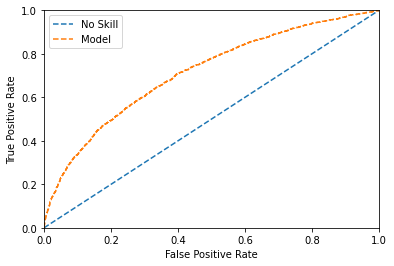

accuracy: 82.44%
precision: 20.49%
recall: 40.39%
[[17310  2782]
 [ 1058   717]]


array([9.32655175e-04, 1.33975248e-04, 9.58617246e-04, 1.10478262e-03,
       1.58710332e-03, 6.97074534e-03, 3.55566744e-04, 3.11525199e-04,
       4.09066301e-04, 5.14490717e-04, 1.15382362e-03, 3.57117434e-04,
       3.52476293e-04, 1.13782107e-03, 1.44814412e-04, 3.47783399e-05,
       1.82604928e-04, 9.86563089e-05, 7.25375616e-03, 9.26346414e-03,
       7.61272120e-03, 9.62107358e-03, 1.32852237e-01, 1.65007101e-02,
       1.16787717e-02, 6.02215939e-02, 2.14288571e-02, 7.00489920e-03,
       8.81200534e-03, 8.45675253e-03, 8.78168115e-03, 5.38809351e-02,
       1.23998459e-01, 2.12313889e-03, 2.63350204e-03, 2.56578182e-03,
       4.34250198e-03, 3.90715831e-03, 1.22863751e-03, 2.36188961e-03,
       3.24322957e-03, 7.75819320e-03, 3.32865326e-03, 2.72159425e-03,
       2.44139245e-03, 6.36712529e-03, 3.00350416e-03, 2.58521795e-03,
       3.39169609e-03, 2.96617092e-03, 5.33800048e-03, 4.93133262e-03,
       7.03522394e-03, 3.87032005e-03, 6.55004756e-03, 2.09136887e-02,
      

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=19, bootstrap=True)


rf.fit(X_train_dummies_resampled, y_train_resampled)

# predict probabilities
rf_probs = rf.predict_proba(X_test_dummies.to_numpy())
rf_probs = rf_probs[:,1]
plot_roc_curve(y_test, rf_probs)
# keep for the positive outcome only
y_pred = (rf_probs > 0.3).astype(int)
print('accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
print('precision: {:.2f}%'.format(precision_score(y_test, y_pred)*100))
print('recall: {:.2f}%'.format(recall_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
# import math

# n_estimators =  [100]
# max_depth = [19]
# learning_rate = [0.01, 0.001, 0.1]
# min_child_weight = [1]
# gamma =  [0.2]
# reg_alpha = [0]
# subsample = [0.9]
# colsample_bytree = [0.6]
# #max_delta_step = [int(x) for x in np.linspace(start=0, stop=5, num=6)]
# scale_pos_weight = [np.sum(y_train_resampled == 0)/np.sum(y_train_resampled == 1)]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'learning_rate': learning_rate,
#                'min_child_weight':min_child_weight,
#                'gamma': gamma,
#                #'max_delta_step' : max_delta_step 
#                'colsample_bytree':colsample_bytree,
#                'subsample': subsample,
#                'reg_alpha': reg_alpha,
#                'scale_pos_weight':scale_pos_weight
#                }
# print(random_grid)
# # initialize the model 
# xgb = XGBClassifier()
# # search across 100 different combinations, and use all available cores
# xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, scoring = 'roc_auc', n_iter = 482, cv = 3, verbose=2, random_state=2020)
# # Fit the random search model
# #xgb_random.fit(train_x_selected.to_numpy(), train_y)
# xgb_random.fit(X_train_dummies_resampled, y_train_resampled)
# print(xgb_random.best_params_)

# y_pred = xgb_random.predict(X_test_dummies.to_numpy())
# print('accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
# print('precision: {:.2f}%'.format(precision_score(y_test, y_pred)*100))
# print('recall: {:.2f}%'.format(recall_score(y_test, y_pred)*100))
# print(confusion_matrix(y_test, y_pred))

# # predict probabilities
# xgb_probs = xgb_random.predict_proba(X_test_dummies.to_numpy())
# # keep for the positive outcome only
# xgb_probs = xgb_probs[:,1]
# plot_roc_curve(y_test, xgb_probs)

{'n_estimators': [100], 'max_depth': [19], 'learning_rate': [0.01, 0.001, 0.1], 'min_child_weight': [1], 'gamma': [0.2], 'colsample_bytree': [0.6], 'subsample': [0.9], 'reg_alpha': [0], 'scale_pos_weight': [1.4310091203295088]}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] subsample=0.9, scale_pos_weight=1.4310091203295088, reg_alpha=0, n_estimators=100, min_child_weight=1, max_depth=19, learning_rate=0.01, gamma=0.2, colsample_bytree=0.6 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=482. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

No Skill: ROC AUC=0.500
Model: ROC AUC=0.731


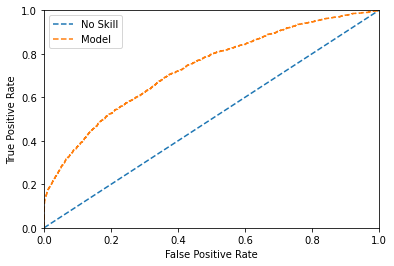

accuracy: 67.05%
precision: 14.97%
recall: 65.35%
[[13502  6590]
 [  615  1160]]


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
param_dist = {'subsample': 0.9, 
              'scale_pos_weight': 1.4364028635873296, 
              'reg_alpha': 0, 'n_estimators': 100, 
              'min_child_weight': 1, 
              'max_depth': 19, 
              'learning_rate': 0.01, 
              'gamma': 0.2, 
              'colsample_bytree': 0.6}
xgb = XGBClassifier(**param_dist)


xgb.fit(X_train_dummies_resampled, y_train_resampled)

# predict probabilities
xgb_probs = xgb.predict_proba(X_test_dummies)
xgb_probs = xgb_probs[:,1]
plot_roc_curve(y_test, xgb_probs)
# keep for the positive outcome only
y_pred = (xgb_probs > 0.3).astype(int)
print('accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
print('precision: {:.2f}%'.format(precision_score(y_test, y_pred)*100))
print('recall: {:.2f}%'.format(recall_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

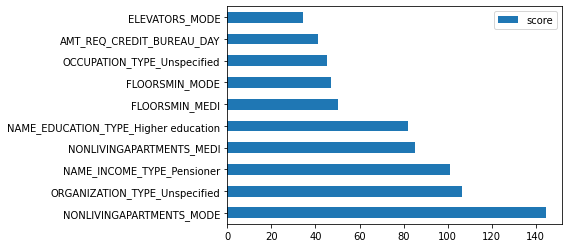

In [ ]:
feature_important = xgb.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[0:10].plot(kind='barh')